In [1]:
import geopandas as gpd
import numpy as np

import pygmo as pg

from scipy import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
%matplotlib inline

In [2]:
n_sensors = 20

## Load Data

Processed in population_data.ipynb notebook.

In [3]:
tyne_oa = gpd.read_file("../data/processed/tyne_oa")
tyne_oa.head()

,oa11cd,lad11cd,X,Y,Population,geometry
0,E00042042,E08000021,421259.393,564639.754,310,"POLYGON ((421301.772 564928.429, 421301.755 56..."
1,E00042043,E08000021,420448.616,564819.213,304,"POLYGON ((420572.364 564892.821, 420572.312 56..."
2,E00042044,E08000021,420509.207,564622.209,246,"POLYGON ((420492.559 564780.806, 420492.590 56..."
3,E00042045,E08000021,421551.722,564088.460,201,"POLYGON ((421543.715 563955.116, 421542.251 56..."
4,E00042046,E08000021,422116.597,563648.529,424,"POLYGON ((422650.214 563568.422, 422650.020 56..."


In [4]:
print(tyne_oa.X.min(), tyne_oa.X.max())
print(tyne_oa.Y.min(), tyne_oa.Y.max())

413067.0710000005 429849.7170000002
563224.0130000003 577386.1339999996


In [5]:
populations = tyne_oa["Population"]

## Calculate Distances Between Output Areas

In [6]:
centroids = np.array([tyne_oa["X"], tyne_oa["Y"]]).T
centroids.shape

(952, 2)

In [7]:
dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

distances = np.sqrt(dist_sq)

Max distance of 16923.71770783074 m is between E00042743 and E00139704


<ipython-input-8-8eef8b4f6df4>:9: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax,


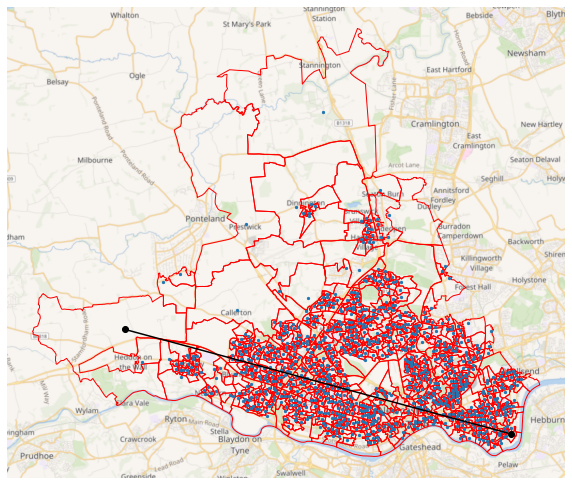

In [8]:
max_idx = np.where(distances == distances.max())[0]
print("Max distance of",
      distances.max(),
      "m is between",
      tyne_oa.iloc[max_idx[0]]["oa11cd"],
      "and", tyne_oa.iloc[max_idx[1]]["oa11cd"])

ax = tyne_oa.plot(figsize=(10,10), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa["X"]
y = tyne_oa["Y"]
ax.scatter(x, y, s=5)

x = tyne_oa.iloc[max_idx]["X"]
y = tyne_oa.iloc[max_idx]["Y"]
ax.plot(x, y, 'k-o')

ax.set_axis_off()

## Calculate "coverage"

coverage at any output area due to a sensor placed in any other output area.

In [9]:
def distance_to_coverage(distance, theta=1):
    return np.exp(- distance / theta)

distance_to_coverage = np.vectorize(distance_to_coverage)

Text(0, 0.5, 'coverage')

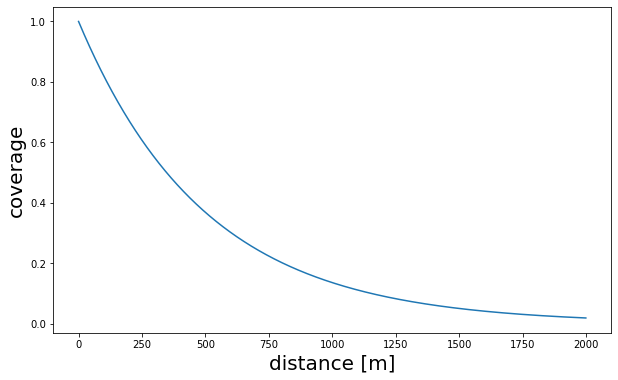

In [10]:
theta = 500

d = np.arange(0, 2000)
plt.figure(figsize=(10,6))
plt.plot(d, distance_to_coverage(d, theta=theta))
plt.xlabel("distance [m]", fontsize=20)
plt.ylabel("coverage", fontsize=20)

#plt.tight_layout()
#plt.savefig("../data/img/coverage_metric.png")

In [11]:
# "coverage" at each output area due to a sensor at any other output area
coverage = distance_to_coverage(distances, theta=theta)

<ipython-input-12-e330865a8002>:10: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax,


Text(0.5, 1.0, 'coverage due to sensor at E00042042')

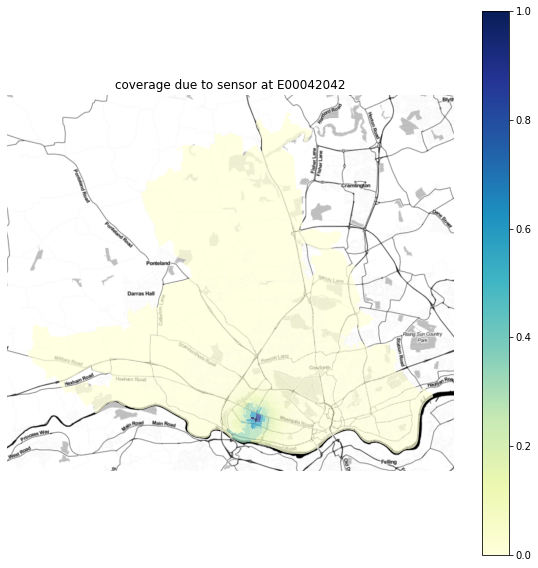

In [12]:
# coverage due to sensor at this output area index
sensor_idx = 0

tyne_oa["coverage"] = coverage[sensor_idx]

ax = tyne_oa.plot(column="coverage",
                  figsize=(10,10),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()
plt.title("coverage due to sensor at " +
          tyne_oa.iloc[sensor_idx]["oa11cd"])

In [13]:
def plot_sensors(sensors,
                 figsize=(20,20),
                 print_sensors=True,
                 save_path=None):
    """
    Plot map with sensor locations (red points), output area centroids (black points),
    and coverage (shaded areas).
    """
    # only keep coverages due to output areas where a sensor is present
    mask_cov = np.multiply(coverage, sensors[np.newaxis, :])

    # coverage at each output area = coverage due to nearest sensor
    max_mask_cov = np.max(mask_cov, axis=1)

    # population weighted average coverage
    avg_coverage = (populations * max_mask_cov).sum() / populations.sum()
    
    tyne_oa["coverage"] = max_mask_cov

    # to make colorbar same size as graph:
    # https://www.science-emergence.com/Articles/How-to-match-the-colorbar-size-with-the-figure-size-in-matpltolib-/
    ax = plt.figure(figsize=figsize).gca()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax = tyne_oa.plot(column="coverage",
                      alpha=0.75,
                      cmap="plasma", legend=True,
                      ax=ax, cax=cax)


    x = tyne_oa[sensors == 1]["X"]
    y = tyne_oa[sensors == 1]["Y"]
    ax.scatter(x, y, s=24, color='r')

    x = tyne_oa[sensors == 0]["X"]
    y = tyne_oa[sensors == 0]["Y"]
    ax.scatter(x, y, s=4, color='k')


    ctx.add_basemap(ax,
                    url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                    crs=tyne_oa.crs)

    ax.set_axis_off()
    ax.set_title("n_sensors = {:.0f}, coverage = {:.2f}".format(sensors.sum(), avg_coverage),
                fontsize=20)
    
    # output areas with sensors
    if print_sensors:
        print("Output areas with sensors:",
              tyne_oa[sensors == 1]["oa11cd"].values)
        
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)

## scipy optimize

In [14]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=20, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        self.theta = theta
        
        self.distance_to_coverage = np.vectorize(self._scalar_coverage)        
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        
        # convert 1D sensors vector into 2D array of X,Y coordinates
        sensors = sensors.reshape(self.n_sensors, 2)
        
        # calculate distance between sensors and output area centroids
        distances = self.calc_distances(sensors, centroids)

        # convert distances to coverage values
        # (coverage at each output area due to each sensor)
        coverage = self.distance_to_coverage(distances, theta=self.theta)
        

        # coverage at each output area = coverage due to nearest sensor
        max_cov = np.max(coverage, axis=0)
        
        # Total population-weighted coverage of solution = our objective
        fitness_sensors = -(self.populations * max_cov).sum() / self.populations.sum()

        return [fitness_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        min_xy = self.centroids.min(axis=0)
        max_xy = self.centroids.max(axis=0)
        
        return (list(min_xy)*self.n_sensors,
                list(max_xy)*self.n_sensors)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def calc_distances(self, sensors, centroids):
        """distance between sensor locations and output area centroids"""
        dist_sq = np.sum((sensors[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                         axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_coverage(self, distance, theta):
        return np.exp(- distance/ theta)

In [15]:
prob = population_optimisation(centroids,
                               populations,
                               n_sensors,
                               theta)

In [16]:
def objective(x):
    fitness = prob.fitness(x)
    return fitness[0]

In [17]:
x_range = [tyne_oa.X.min(), tyne_oa.X.max()]
print(x_range)
y_range = [tyne_oa.Y.min(), tyne_oa.Y.max()]
print(y_range)

x_mid = np.mean(x_range)
y_mid = np.mean(y_range)

init_sensors = [x_mid if x%2==0 else y_mid for x in range(2*n_sensors)]

sensor_bounds = [x_range if x%2==0 else y_range for x in range(2*n_sensors)]

[413067.0710000005, 429849.7170000002]
[563224.0130000003, 577386.1339999996]


In [20]:
# init sensors to mid-points
points = optimize.minimize(objective, init_sensors)

points

      fun: -0.004671948229816732
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([-4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.36791810e-07,
       -4.27942723e-06, -6.36791810e-07, -4.27942723e-06, -6.3679

In [ ]:
# SLOW! ~30s per iteration
maxiter = 100

def cback(xk, convergence=0):
    print("Convergence:", round(convergence*100, 2), "%")
    print("Current solution:", xk)
    print("-" * 20)

import time
t = time.time()
points = optimize.differential_evolution(
    objective, sensor_bounds, maxiter=maxiter, callback=cback
)
print("Took", time.time() - t, "seconds")
points